# Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_forecasting-USU/blob/main/Lectures%20and%20codes/Module%207-%20Deep%20Sequence%20Modeling/Module7_Deep_sequence_modeling_temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center)


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 7- Deep Sequence Modeling (Timeseries forecasting with multiple features)

This module provides a comprehensive overview of fundamental concepts and techniques related to deep sequence modeling. Part one explores deep learning for timeseries data, highlighting the inadequacy of DNN and CNN architectures for this task and introducing the recurrent neural network (RNN) as a solution. Part two delves into deep learning for natural language processing (NLP), illustrating how neural networks can be employed to process human language. The module concludes with a practical exercise in which students apply the concepts they have learned to build a deep sequence model and perform NLP tasks using TensorFlow in Python.

This notebook has been adapted from Deep learning with Python (2nd edition). Francois Chollet
https://github.com/fchollet/deep-learning-with-python-notebooks

# Installation

* If you want to run your code on Google Colab, there is no installation required. (recommended for the course)
* If you want to run your code locally, then you need to install tensorflow https://www.tensorflow.org/install



In [1]:
import tensorflow
tensorflow.__version__

'2.15.0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## A temperature-forecasting example

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-03 16:31:07--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.52.248, 16.182.36.112, 52.216.61.200, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.52.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.9MB/s    in 0.9s    

2024-04-03 16:31:09 (13.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))
print(lines[0:1])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30']


In [5]:
lines[0].split(",")[1:]


['996.52',
 '-8.02',
 '265.40',
 '-8.90',
 '93.30',
 '3.33',
 '3.11',
 '0.22',
 '1.94',
 '3.12',
 '1307.75',
 '1.03',
 '1.75',
 '152.30']

**Parsing the data**

In [6]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

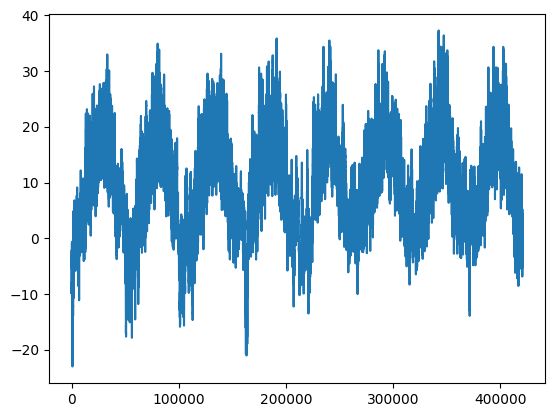

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

**Plotting the first 10 days of the temperature timeseries**

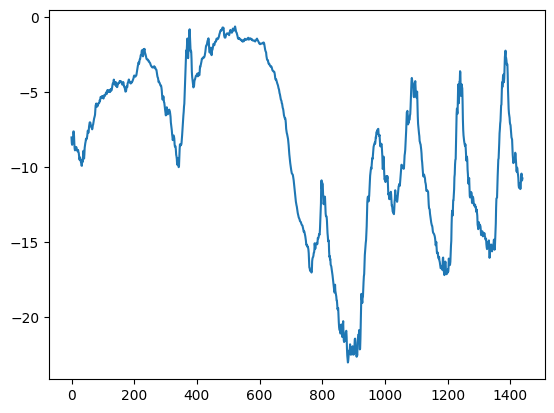

In [8]:
plt.plot(range(1440), temperature[:1440])
plt.show()

**Computing the number of samples we'll use for each data split**

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [11]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [12]:
for inputs, targets in dummy_dataset:
  print(inputs.shape)
  print(targets.shape)
  break

(2, 3)
(2,)


**Instantiating datasets for training, validation, and testing**

In [13]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [14]:
raw_data.shape

(420451, 14)

**Inspecting the output of one of our datasets**

In [15]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [16]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [17]:
raw_data.shape[-1]

14

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 38s 43ms/step - loss: 14.6328 - mae: 2.9489 - val_loss: 10.4305 - val_mae: 2.5486
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 9.8821 - mae: 2.4772 - val_loss: 10.5027 - val_mae: 2.5659
Epoch 3/10
819/819 [==============================] - 44s 54ms/step - loss: 9.0805 - mae: 2.3772 - val_loss: 10.1301 - val_mae: 2.5199
Epoch 4/10
819/819 [==============================] - 35s 43ms/step - loss: 8.3132 - mae: 2.2732 - val_loss: 12.4896 - val_mae: 2.7997
Epoch 5/10
819/819 [==============================] - 34s 41ms/step - loss: 7.8772 - mae: 2.2124 - val_loss: 10.7794 - val_mae: 2.5915
Epoch 6/10
819/819 [==============================] - 43s 53ms/step - loss: 7.5728 - mae: 2.1715 - val_loss: 10.8757 - val_mae: 2.6041
Epoch 7/10
819/819 [==============================] - 33s 41ms/step - loss: 7.3304 - mae: 2.1353 - val_loss: 11.3346 - val_mae: 2.6626
Epoch 8/10
819/819 [==============================] - 

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26913 (105.13 KB)
Trainable params: 26913 (105.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
120*14

1680

**Plotting results**

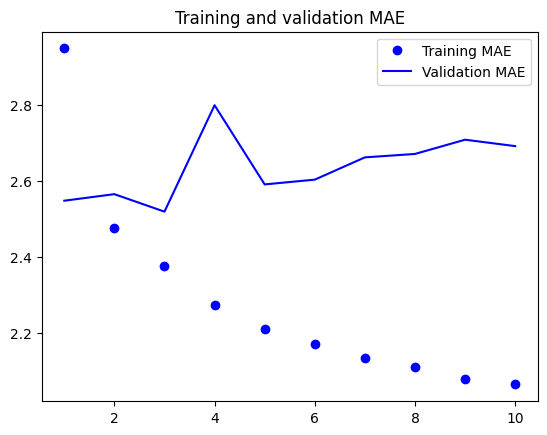

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 56ms/step - loss: 21.8199 - mae: 3.6562 - val_loss: 15.6466 - val_mae: 3.1101
Epoch 2/10
819/819 [==============================] - 51s 61ms/step - loss: 15.4064 - mae: 3.1333 - val_loss: 16.6970 - val_mae: 3.2858
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 14.3403 - mae: 3.0210 - val_loss: 15.2944 - val_mae: 3.0701
Epoch 4/10
819/819 [==============================] - 36s 43ms/step - loss: 13.5520 - mae: 2.9278 - val_loss: 16.8037 - val_mae: 3.2889
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 12.8642 - mae: 2.8449 - val_loss: 14.8094 - val_mae: 3.0566
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 12.3082 - mae: 2.7821 - val_loss: 15.3848 - val_mae: 3.0974
Epoch 7/10
819/819 [==============================] - 45s 54ms/step - loss: 11.9383 - mae: 2.7393 - val_loss: 18.8215 - val_mae: 3.4119
Epoch 8/10
819/819 [============================

In [ ]:
24*14*8+8

2696

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 8)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

### A first recurrent baseline

**A simple RNN model**

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.SimpleRNN(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_RNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_RNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 103s 122ms/step - loss: 45.8699 - mae: 4.9575 - val_loss: 13.3206 - val_mae: 2.7270
Epoch 2/10
819/819 [==============================] - 99s 121ms/step - loss: 11.4060 - mae: 2.6153 - val_loss: 9.5060 - val_mae: 2.3976
Epoch 3/10
819/819 [==============================] - 97s 119ms/step - loss: 10.4945 - mae: 2.5238 - val_loss: 9.3280 - val_mae: 2.3735
Epoch 4/10
819/819 [==============================] - 99s 120ms/step - loss: 10.3480 - mae: 2.5066 - val_loss: 9.2478 - val_mae: 2.3693
Epoch 5/10
819/819 [==============================] - 97s 118ms/step - loss: 10.2357 - mae: 2.4943 - val_loss: 9.3363 - val_mae: 2.3828
Epoch 6/10
819/819 [==============================] - 98s 119ms/step - loss: 10.1267 - mae: 2.4825 - val_loss: 9.1842 - val_mae: 2.3609
Epoch 7/10
819/819 [==============================] - 95s 116ms/step - loss: 10.0456 - mae: 2.4741 - val_loss: 9.1512 - val_mae: 2.3551
Epoch 8/10
819/819 [==========================

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                496       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


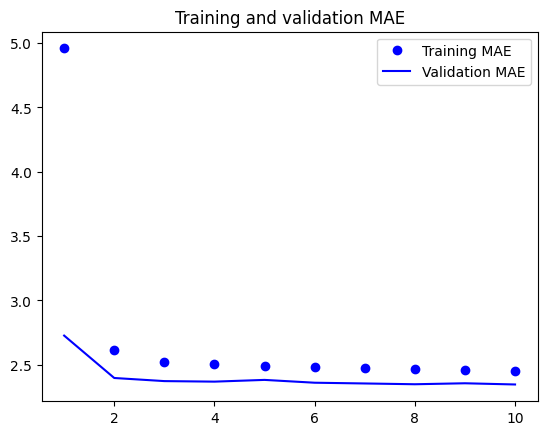

In [23]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**A simple LSTM-based model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 57ms/step - loss: 44.1332 - mae: 4.8653 - val_loss: 13.3132 - val_mae: 2.7705
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 11.1683 - mae: 2.6006 - val_loss: 9.5313 - val_mae: 2.4058
Epoch 3/10
819/819 [==============================] - 37s 45ms/step - loss: 9.7673 - mae: 2.4355 - val_loss: 9.4751 - val_mae: 2.3937
Epoch 4/10
819/819 [==============================] - 38s 46ms/step - loss: 9.2700 - mae: 2.3691 - val_loss: 9.5289 - val_mae: 2.4048
Epoch 5/10
819/819 [==============================] - 37s 44ms/step - loss: 8.9227 - mae: 2.3221 - val_loss: 9.8634 - val_mae: 2.4435
Epoch 6/10
819/819 [==============================] - 37s 45ms/step - loss: 8.6254 - mae: 2.2827 - val_loss: 9.9130 - val_mae: 2.4479
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 8.4607 - mae: 2.2620 - val_loss: 10.0815 - val_mae: 2.4581
Epoch 8/10
819/819 [==============================] - 37s 

In [ ]:
4*((14*16) + (16*16) + 16 )

1984

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 268s 322ms/step - loss: 26.2188 - mae: 3.7938 - val_loss: 10.1111 - val_mae: 2.4598
Epoch 2/10
819/819 [==============================] - 264s 322ms/step - loss: 14.8213 - mae: 2.9893 - val_loss: 9.4588 - val_mae: 2.3846
Epoch 3/10
819/819 [==============================] - 265s 323ms/step - loss: 13.7971 - mae: 2.8835 - val_loss: 9.2967 - val_mae: 2.3741
Epoch 4/10
819/819 [==============================] - 265s 324ms/step - loss: 13.2527 - mae: 2.8256 - val_loss: 9.4014 - val_mae: 2.3854
Epoch 5/10
819/819 [==============================] - 267s 326ms/step - loss: 12.7385 - mae: 2.7697 - val_loss: 9.4024 - val_mae: 2.3814
Epoch 6/10
819/819 [==============================] - 265s 323ms/step - loss: 12.2762 - mae: 2.7213 - val_loss: 9.3268 - val_mae: 2.3862
Epoch 7/10
819/819 [==============================] - 268s 327ms/step - loss: 11.9535 - mae: 2.6863 - val_loss: 9.5986 - val_mae: 2.4024
Epoch 8/10
819/819 [====================

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 495s 599ms/step - loss: 23.7298 - mae: 3.6159 - val_loss: 9.3713 - val_mae: 2.3694
Epoch 2/10
819/819 [==============================] - 490s 598ms/step - loss: 14.0022 - mae: 2.8993 - val_loss: 8.7468 - val_mae: 2.2913
Epoch 3/10
819/819 [==============================] - 501s 612ms/step - loss: 13.2884 - mae: 2.8254 - val_loss: 8.7882 - val_mae: 2.2989
Epoch 4/10
819/819 [==============================] - 494s 603ms/step - loss: 12.6892 - mae: 2.7634 - val_loss: 8.7224 - val_mae: 2.2832
Epoch 5/10
819/819 [==============================] - 493s 601ms/step - loss: 12.2015 - mae: 2.7118 - val_loss: 8.6887 - val_mae: 2.2811
Epoch 6/10
522/819 [==================>...........] - ETA: 2:47 - loss: 11.7948 - mae: 2.6690

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

In [ ]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Done!